In [1]:
# libraries
import pandas as pd
import fastai
from fastai.vision import *

In [2]:
path = Path('data/widsdatathon2019/')

In [3]:
ls {path}

SampleSubmission.csv*         models/
data/                         solutionFile.csv*
holdout.csv*                  testlabels.csv*
leaderboard_holdout_data/     train_images/
leaderboard_holdout_data.zip* train_images.zip*
leaderboard_test_data/        traininglabels.csv
leaderboard_test_data.zip*


In [4]:
train = 'train_images'
test = path/'leaderboard_test_data/'
holdout = path/'leaderboard_holdout_data/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'
model_directory = path/'models/'

In [5]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [6]:
df.head()

,image_id,has_oilpalm,score
0,img_00000.jpg,0,0.7895
1,img_00001.jpg,0,1.0000
2,img_00002.jpg,0,1.0000
3,img_00007.jpg,0,1.0000
4,img_00008.jpg,0,1.0000


In [7]:
df.describe()

,has_oilpalm,score
count,15057.000000,15057.000000
mean,0.062164,0.955851
std,0.241461,0.109164
min,0.000000,0.388700
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [8]:
(df.has_oilpalm==1).sum()

936

In [9]:
test_ids = [f for f in test.iterdir()]
holdout_ids = [f for f in holdout.iterdir()]

In [10]:
src = (ImageList.from_df(df, path, folder=train)
      .random_split_by_pct(0.2, seed=2019)
      .label_from_df('has_oilpalm')
      .add_test(test_ids+holdout_ids))

In [11]:
data =  (src.transform(get_transforms(), size=128)
         .databunch(bs=64)
         .normalize(imagenet_stats))

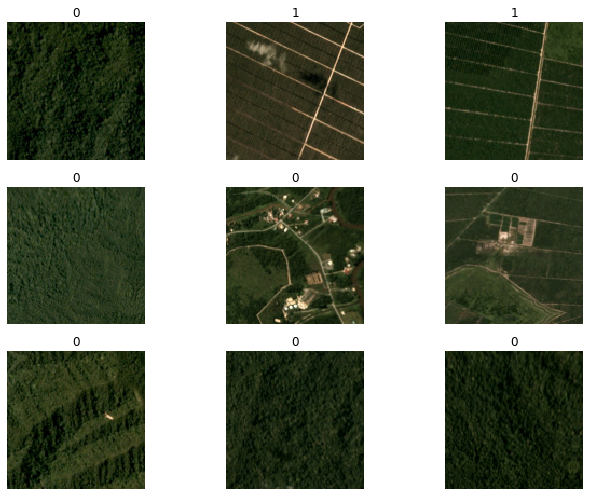

In [12]:
data.show_batch(3, figsize=(10,7))

In [13]:
from sklearn.metrics import roc_auc_score
def auc_score(preds,targets):
    return torch.tensor(roc_auc_score(targets,preds[:,1]))

In [15]:
learn = cnn_learner(data, models.resnet18, 
                   metrics=[accuracy],
                   model_dir=model_directory)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


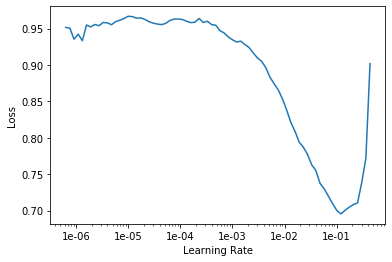

In [15]:
learn.lr_find(); learn.recorder.plot()

In [16]:
lr = 1e-2

In [17]:
learn.fit_one_cycle(6,lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.257857,0.211385,0.931252,12:42
1,0.224107,0.225772,0.931252,10:23
2,0.199272,0.197565,0.925938,10:39
3,0.193576,0.201984,0.933245,10:22
4,0.197562,0.196869,0.927599,10:24
5,0.187082,0.196595,0.932581,10:50


In [18]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.186179,0.206162,0.932248,14:24
1,0.179330,0.202446,0.927599,14:29
2,0.182768,0.194753,0.933245,14:28


In [19]:
learn.save('128')

In [19]:
p,t = learn.get_preds()
auc_score(p,t)

tensor(0.6654)

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

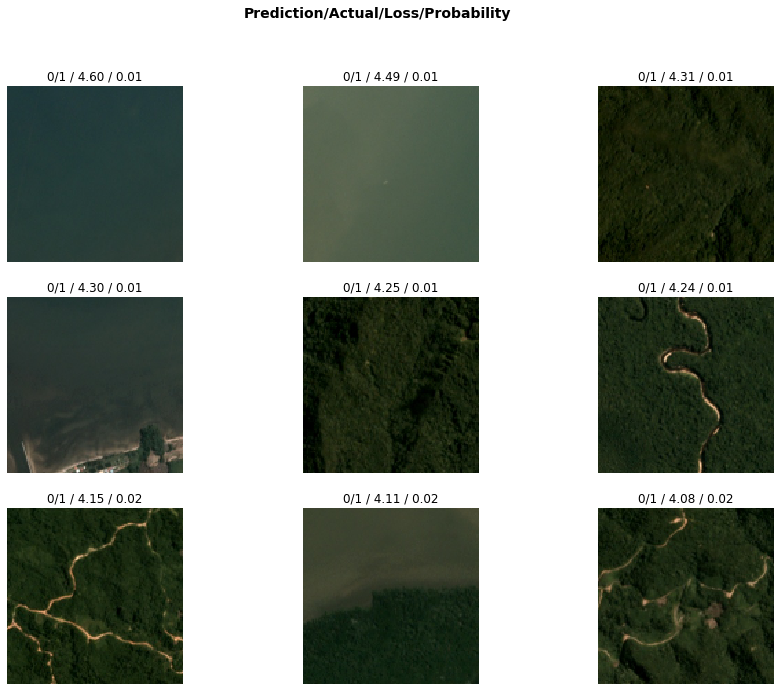

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [17]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (12046 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: data/widsdatathon2019;

Valid: LabelList (3011 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: data/widsdatathon2019;

Test: LabelList (11192 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data/widsdatathon2019, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv